In [578]:
from skimage import data
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [579]:
import cv2

## Вспомагательные функции

In [580]:
def read_image(path):
    return cv2.imread(path)

In [581]:
def show_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

In [582]:
def draw_contours(image, contours):
    image_copy = image.copy()
    cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA);
    return image_copy

## Нахождения контуров

In [724]:
# получает изображение
# находит контуры на изображении и возвращает массив контуров
def find_contours(image):
    blurred = cv2.GaussianBlur(image, (3, 3), 0)
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(img_gray, 110, 255, cv2.THRESH_BINARY_INV )
    contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE) 
    return contours

In [584]:
# получает на вход массив контуров на изображении
# находит контуры фишек и апроксимирует их, возвращает массив контуров фишек и массив периметров фишек
def find_angles_and_per(contours, eps=0.025):
    angles_all = []
    p_all = []
    for i in range(len(contours)):
        p = cv2.arcLength(contours[i], True)
        angles = cv2.approxPolyDP(contours[i], eps * p, True)
        angles = cv2.convexHull(angles)
        per = cv2.arcLength(angles, True)
        p_all.append(per)
        angles_all.append(angles)
        
       
    p_all = np.array(p_all)
    angles_all = angles_all
    
    ind = np.argsort(p_all)
    p_all = p_all[ind][::-1]
    angles_all = [angles_all[i] for i in ind][::-1]
    
    i = 0
    while True:
        p_max = p_all[i]
        if i+1 < len(p_all) and p_max-p_all[(i+1)] > 50:
            i += 1
            continue
        break
        
    p_all = p_all[i:][::-1]
    angles_all = angles_all[i:][::-1]
    
    p_answ = []
    angles_answ = []
    for i in range(len(p_all)):
        if (p_max - p_all[i]) < 50:
            p_answ.append(p_all[i])
            angles_answ.append(angles_all[i])
    
    
    return angles_answ, p_answ

In [585]:
# находит контур одной фишки и апроксимирует его, возвращает массив контуров фишек и массив периметров фишек
def find_angle(contours, eps=0.001):
    angles_all = []
    p_all = []
    for i in range(len(contours)):
        p = cv2.arcLength(contours[i], True)
        angles = cv2.approxPolyDP(contours[i], eps * p, True)
        angles = cv2.convexHull(angles)
        per = cv2.arcLength(angles, True)
        p_all.append(per)
        angles_all.append(angles)
        
    
    p_all = np.array(p_all)
    angles_all = angles_all
    
    ind = np.argsort(p_all)
    p_all = p_all[ind][::-1]
    angles_all = [angles_all[i] for i in ind][::-1]
    
    return [angles_all[0]], [p_all[0]]

# Функция подсчета фишек

In [586]:
def count_chips(image):
    contures = find_contours(image)
    _, p = find_angles_and_per(contures)
    return len(p)

In [634]:
## для запуска
# im = read_image('Group_#.bmp')
# show_image(im)
# count_chips(im) 

### Примеры работы

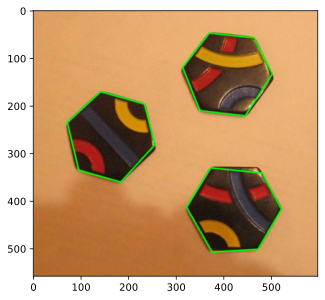

In [588]:
im1 = read_image('Group_1.bmp')
c = find_contours(im1)
c, _ = find_angles_and_per(c)
show_image(drow_contours(im1, c))
plt.savefig('contours_1.jpg')

3

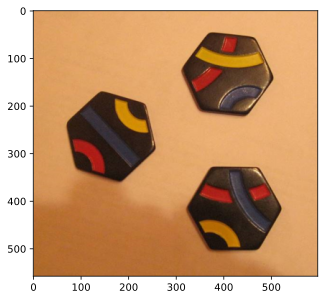

In [589]:
im1 = read_image('Group_1.bmp')
show_image(im1)
count_chips(im1)

3

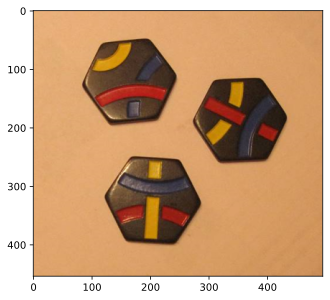

In [591]:
im2 = read_image('Group_3.bmp')
show_image(im2)
count_chips(im2)

10

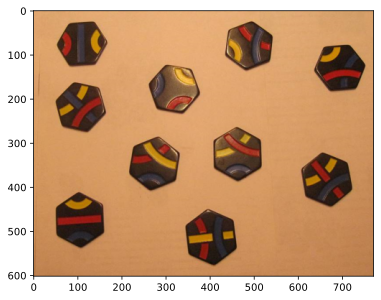

In [636]:
im3 = read_image('Group_5.bmp')
show_image(im3)
count_chips(im3)

## Определение цветов и дуг

In [639]:
def color_mask(image, h_min, h_max):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV )
    thresh = cv2.inRange(hsv, h_min, h_max)
    return thresh

In [640]:
# angles - массив углов на всех фишках
# возвращает список массвов центров на всех фишках
def find_centers(angles):
    c = []
    for f in angles:
        c_f = []
        for i in range(len(f)):
            points = f[i]
            points_2 = f[(i+1) % len(f)]
            x_1 = points[0][0]
            y_1 = points[0][1]
            x_2 = points_2[0][0]
            y_2 = points_2[0][1]
            x_c = (x_1 + x_2) // 2
            y_c = (y_1 + y_2) // 2
            c_f.append([[x_c, y_c]])
        c_f = np.array(c_f)
        c.append(c_f)
    return c

In [749]:
# answ[i] = j, i - цвет (0 - желтый, 1 - красный, 2 - синий); j - кривизна (1 - малая, 2 - большая, 3 - прямая)
# image - изображение с одной фишкой
def color_and_size(image, return_contours = False):
    answ = np.zeros(3)

    contr = find_contours(image) # контур фишки на изображении (np.array())
    angles, p = find_angle(contr) # список углов для фишки на изображении [np.array()]
    
    for i in range(len(angles)):
        angles[i] = cv2.approxPolyDP(angles[i], 0.025 * p[0], True)
        angles[i] = cv2.convexHull(angles[i])
    
    dis = []
    if len(angles[0]) > 6:
        for i in range(len(angles[0])):
            x1 = angles[0][i][0][0]
            y1 = angles[0][i][0][1]
            x2 = angles[0][(i+1) % len(angles[0])][0][0]
            y2 = angles[0][(i+1) % len(angles[0])][0][1]
            dx = x1 - x2
            dy = y1 - y2
            r = np.sqrt(dx * dx + dy * dy)
            dis.append(r)
        ind = np.argsort(dis)
        angles[0] = np.delete(angles[0], ind[:len(angles[0]) - 6], axis=0)
            

    centers = find_centers(angles) # центры граней для фишки [np.array(), ...]
    count_contours = []
    
    
    
    hsv_min_y = np.array((16, 172, 158), np.uint8)
    hsv_max_y = np.array((168, 255, 220), np.uint8)
    hsv_min_b = np.array((87, 0, 36), np.uint8)
    hsv_max_b = np.array((171, 79, 158), np.uint8)
    hsv_min_r = np.array((0, 190, 140), np.uint8)
    hsv_max_r = np.array((17, 255, 255), np.uint8)
    
    
    #желтый
    mask_y = color_mask(image, hsv_min_y, hsv_max_y)
    contours_y, _ = cv2.findContours(image=mask_y, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE) 
    
    #красный
    mask_r = color_mask(image, hsv_min_r, hsv_max_r)
    contours_r, _ = cv2.findContours(image=mask_r, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE) 
    
    #синий
    mask_b = color_mask(image, hsv_min_b, hsv_max_b)
    contours_b, _ = cv2.findContours(image=mask_b, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE) 
    
    #show_image(mask_r)
    color = []
    count = []
    for center in centers[0]:
        x_c = center[0][0]
        y_c = center[0][1]
        f = np.full(mask_y.shape, 0, np.uint8)
        f = cv2.circle(f,(x_c, y_c), int(p[0]/12) ,(255,255,255), -1)
        count.append(np.array([np.sum((f * mask_y) != 0), np.sum((f * mask_r) != 0), np.sum((f * mask_b) != 0)]))
    
    count = np.array(count)
    
    arg = np.argsort(count, axis=0)[::-1, :]
    
    #определяем желтый
    s_1_y, s_2_y = arg[:, 0][:2]
    buf = np.abs(s_1_y - s_2_y)
    if buf > 3:
        answ[0] = int(6 - buf)
    else:
        answ[0] = int(buf)
    
    if answ[0] == 3:
        answ[1] = 2
        answ[2] = 2
        if return_contours:
            return answ, [s_1_y, s_2_y, -1, -1, -1, -1]
        return answ
    
    set_y = {s_1_y, s_2_y}
    
    #определяем красный цвет
    s_1_r, s_2_r = arg[:, 1][:2]
    if s_1_r not in set_y and s_2_r not in set_y:
        buf = np.abs(s_1_r - s_2_r)
        if buf > 3:
            answ[1] = int(6 - buf)
        else:
            answ[1] = int(buf)
        set_yr = {s_1_y, s_2_y, s_1_r, s_2_r}
        s_1_b, s_2_b = {0, 1, 2, 3, 4, 5} - set_yr
        
        buf = np.abs(s_1_b - s_2_b)
        if buf > 3:
            answ[2] = int(6 - buf)
        else:
            answ[2] = int(buf)
        
        if return_contours:
            return answ, [s_1_y, s_2_y, s_1_r, s_2_r, s_1_b, s_2_b]
        return answ
    
    #пробуем определять синий
    s_1_b, s_2_b = arg[:, 2][:2]
    if s_1_b not in set_y and s_2_b not in set_y:
        buf = np.abs(s_1_b - s_2_b)
        if buf > 3:
            answ[2] = int(6 - buf)
        else:
            answ[2] = int(buf)
        set_yb = {s_1_y, s_2_y, s_1_b, s_2_b}
        s_1_r, s_2_r = {0, 1, 2, 3, 4, 5} - set_yb
        
        buf = np.abs(s_1_r - s_2_r)
        if buf > 3:
            answ[1] = int(6 - buf)
        else:
            answ[1] = int(buf)
        
        if return_contours:
            return answ, [s_1_y, s_2_y, s_1_r, s_2_r, s_1_b, s_2_b]
        return answ
    
    #если с синим плохо, доверяем красному
    if s_1_r in set_y and s_2_r not in set_y:
        s_1_r = arg[:, 1][2]
        if s_1_r in set_y:
            s_1_r = arg[:, 1][3]
    elif s_1_r not in set_y and s_2_r in set_y:
        s_2_r = arg[:, 1][2]
        if s_2_r in set_y:
            s_2_r = arg[:, 1][3]
    else:
        s_1_r = arg[:, 1][2]
        s_2_r = arg[:, 1][3]
        
    buf = np.abs(s_1_r - s_2_r)
    if buf > 3:
        answ[1] = int(6 - buf)
    else:
        answ[1] = int(buf)
    set_yr = {s_1_y, s_2_y, s_1_r, s_2_r}
    s_1_b, s_2_b = {0, 1, 2, 3, 4, 5} - set_yr
        
    buf = np.abs(s_1_b - s_2_b)
    if buf > 3:
        answ[2] = int(6 - buf)
    else:
        answ[2] = int(buf)
        
    if return_contours:
        return answ, [s_1_y, s_2_y, s_1_r, s_2_r, s_1_b, s_2_b]
    return answ
    

# Функция определения цвета и размера дуг

In [680]:
def print_color_and_size(image):
    answ = color_and_size(image)
    d_color = {0: 'Желтая дуга ', 1: 'красная дуга ', 2: 'синяя дуга '}
    d_size = {1: 'малой кривизны', 2: 'большой кривизны', 3: 'прямолинейная'}
    
    s = ''
    for i in range(len(answ)):
        s += d_color[i] + d_size[answ[i]]
        if i+1 != len(answ):
            s += ', '
    
    print(s)

In [637]:
#для запуска
# im = read_image(#имя файла)
# show_image(im)
# print_color_and_size(im)

### Примеры работы

In [681]:
im = read_image('Single_1.bmp')
hsv_min_y = np.array((16, 172, 158), np.uint8)
hsv_max_y = np.array((168, 255, 220), np.uint8)
hsv_min_b = np.array((87, 0, 36), np.uint8)
hsv_max_b = np.array((171, 79, 158), np.uint8)
hsv_min_r = np.array((0, 190, 140), np.uint8)
hsv_max_r = np.array((17, 255, 255), np.uint8)
mask_y = color_mask(im, hsv_min_y, hsv_max_y)
mask_r = color_mask(im, hsv_min_r, hsv_max_r)
mask_b = color_mask(im, hsv_min_b, hsv_max_b)

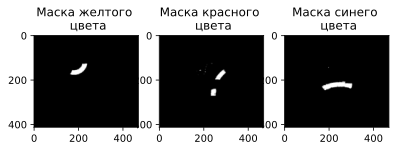

In [682]:
plt.subplot(1, 3, 1)
show_image(mask_y)
plt.title('Маска желтого \n цвета');

plt.subplot(1, 3, 2)
show_image(mask_r)
plt.title('Маска красного \n цвета');

plt.subplot(1, 3, 3)
show_image(mask_b)
plt.title('Маска синего \n цвета');


plt.savefig('mask_y.jpg')

Желтая дуга малой кривизны, красная дуга большой кривизны, синяя дуга большой кривизны


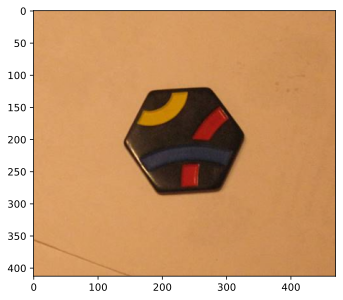

In [683]:
im = read_image('Single_1.bmp')
show_image(im)
print_color_and_size(im)
plt.savefig('Single_1.jpg')

Желтая дуга большой кривизны, красная дуга большой кривизны, синяя дуга малой кривизны


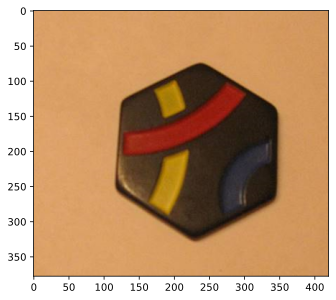

In [684]:
im = read_image('Single_2.bmp')
show_image(im)
print_color_and_size(im)

Желтая дуга малой кривизны, красная дуга малой кривизны, синяя дуга малой кривизны


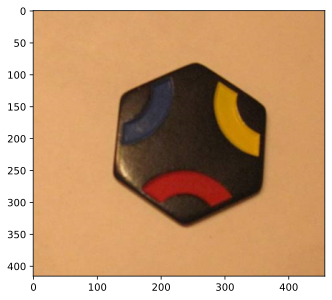

In [685]:
im = read_image('Single_3.bmp')
show_image(im)
print_color_and_size(im)

Желтая дуга малой кривизны, красная дуга прямолинейная, синяя дуга малой кривизны


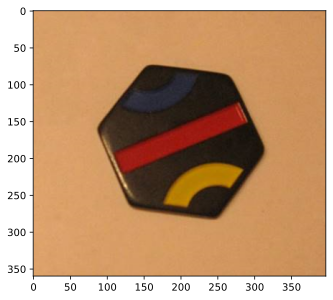

In [686]:
im = read_image('Single_4.bmp')
show_image(im)
print_color_and_size(im)

# Определение типа фишек

In [702]:
def types_chips(image):
    
    types = {(1, 2, 2):[1, 10], (1, 1, 3):[2], (1, 1, 1):[3], (2, 2, 3):[4], (1, 3, 1):[5],
             (3, 2, 2):[6], (2, 2, 1):[7, 8], (2, 3, 2):[9]
            }
    im = image.copy()
    
    contours = find_contours(image)
    angles, _ = find_angles_and_per(contours)
    for i in range(len(angles)):
        x, y, w, h = cv2.boundingRect(angles[i])
        crop_img = im[y-15:y+h+15, x-15:x+w+15]
        buf = color_and_size(crop_img, True)
        arr, s = buf
        arr = arr.astype('int')
        answ = types[tuple(arr)]
        if len(answ) == 2:
            s_1_y, s_2_y, s_1_r, s_2_r, s_1_b, s_2_b = s
            if answ == [1, 10]:
                s_max = max(s_1_y, s_2_y)
                if s_max == 5 and {s_1_y, s_2_y} - {5} == 0:
                    s_max == 0
                
                if (s_max+1) % 6 in {s_1_r, s_2_r}:
                    number = answ[1]
                else:
                    number = answ[0]
            else:
                s_max = max(s_1_b, s_2_b)
                if s_max == 5 and {s_1_b, s_2_b} - {5} == 0:
                    s_max == 0
                
                if s_max+1 in {s_1_y, s_2_y}:
                    number = answ[0]
                else:
                    number = answ[1]
            
        else:
            number = answ[0]
        cv2.putText(im, str(number), (x+15, y+15), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 216, 0), thickness=3)
    
    return im

In [691]:
#для запуска
# im = read_image(#имя файлв)
# im_coor = types_chips(im)
# show_image(im_coor)

### Примеры работы

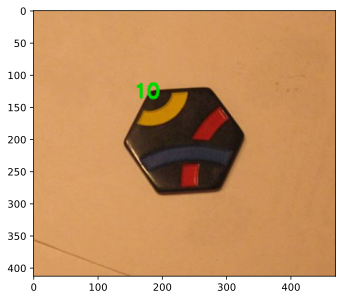

In [725]:
im1 = read_image('Single_1.bmp')
im1_coor = types_chips(im1)
show_image(im1_coor)

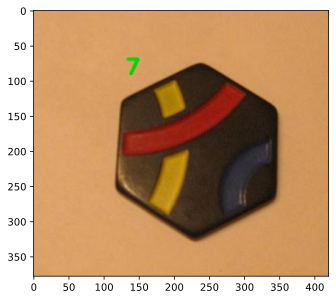

In [726]:
im2 = read_image('Single_2.bmp')
im2_coor = types_chips(im2)
show_image(im2_coor)

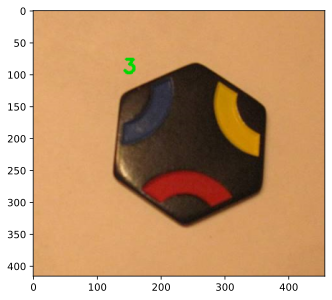

In [727]:
im3 = read_image('Single_3.bmp')
im3_coor = types_chips(im3)
show_image(im3_coor)

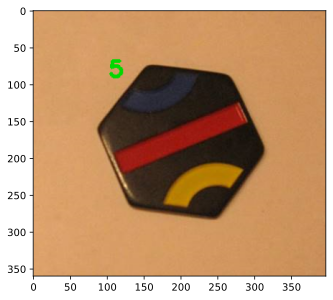

In [728]:
im4 = read_image('Single_4.bmp')
im4_coor = types_chips(im4)
show_image(im4_coor)

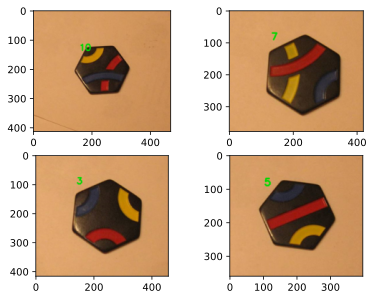

In [729]:
plt.subplot(2, 2, 1)
show_image(im1_coor)

plt.subplot(2, 2, 2)
show_image(im2_coor)

plt.subplot(2, 2, 3)
show_image(im3_coor)

plt.subplot(2, 2, 4)
show_image(im4_coor)

plt.savefig('test_1.jpg')

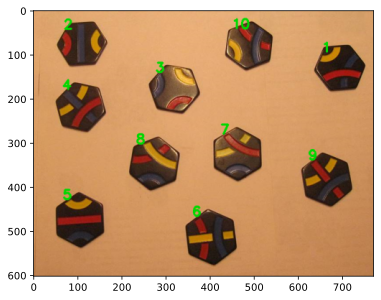

In [730]:
im_5 = read_image('Group_5.bmp')
im_coor_5 = types_chips(im_5)
show_image(im_coor_5)

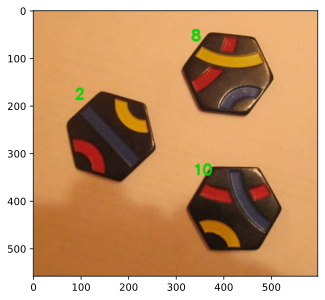

In [750]:
im_1 = read_image('Group_1.bmp')
im_coor_1 = types_chips(im_1)
show_image(im_coor_1)

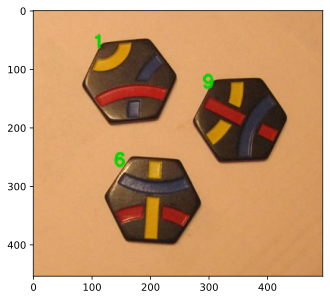

In [733]:
im_3 = read_image('Group_3.bmp')
im_coor_3 = types_chips(im_3)
show_image(im_coor_3)

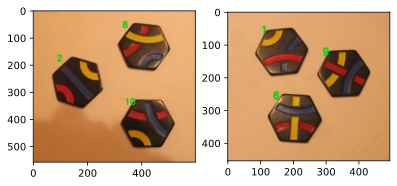

In [662]:
plt.subplot(1, 2, 1)
show_image(im_coor_1)

plt.subplot(1, 2, 2)
show_image(im_coor_3)

plt.savefig('test_3.jpg')

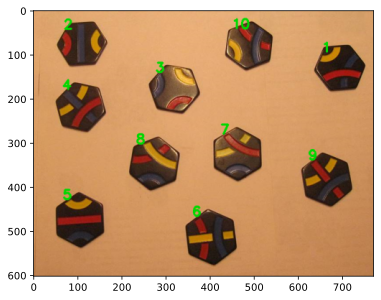

In [735]:
show_image(im_coor_5)
plt.savefig('test_2.jpg')